In [2]:
#Reset kernel when start this notebook
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

spark = SparkSession.builder.master('local[*]').getOrCreate()

sc = spark.sparkContext

spark

In [3]:
import pyarrow.parquet as pq
import pandas as pd

In [4]:
#Read data from files
dataset_parquet = pq.read_table("dataset/yellow_tripdata_2017-01.parquet")
df = dataset_parquet.to_pandas()

In [5]:
#To know the values of the dataframe
df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2017-01-01 00:32:05,2017-01-01 00:37:48,1,1.2,1,N,140,236,2,6.5,0.5,0.5,0.0,0.0,0.3,7.8,None,None
1,1,2017-01-01 00:43:25,2017-01-01 00:47:42,2,0.7,1,N,237,140,2,5.0,0.5,0.5,0.0,0.0,0.3,6.3,None,None
2,1,2017-01-01 00:49:10,2017-01-01 00:53:53,2,0.8,1,N,140,237,2,5.5,0.5,0.5,0.0,0.0,0.3,6.8,None,None
3,1,2017-01-01 00:36:42,2017-01-01 00:41:09,1,1.1,1,N,41,42,2,6.0,0.5,0.5,0.0,0.0,0.3,7.3,None,None
4,1,2017-01-01 00:07:41,2017-01-01 00:18:16,1,3.0,1,N,48,263,2,11.0,0.5,0.5,0.0,0.0,0.3,12.3,None,None


Data dictionary of this dataset can be found in the following link:
https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

In [6]:
#Check data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9710820 entries, 0 to 9710819
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   object        
 18  airport_fee           

In [7]:
#Check null values
df.isnull()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9710815,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
9710816,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
9710817,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
9710818,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True


In [8]:
# As all the values of congestion_surcharge and airport_fee are null, we proceed to delete them
df = df.drop(["airport_fee","congestion_surcharge"], axis=1)
df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2017-01-01 00:32:05,2017-01-01 00:37:48,1,1.2,1,N,140,236,2,6.5,0.5,0.5,0.0,0.0,0.3,7.8
1,1,2017-01-01 00:43:25,2017-01-01 00:47:42,2,0.7,1,N,237,140,2,5.0,0.5,0.5,0.0,0.0,0.3,6.3
2,1,2017-01-01 00:49:10,2017-01-01 00:53:53,2,0.8,1,N,140,237,2,5.5,0.5,0.5,0.0,0.0,0.3,6.8
3,1,2017-01-01 00:36:42,2017-01-01 00:41:09,1,1.1,1,N,41,42,2,6.0,0.5,0.5,0.0,0.0,0.3,7.3
4,1,2017-01-01 00:07:41,2017-01-01 00:18:16,1,3.0,1,N,48,263,2,11.0,0.5,0.5,0.0,0.0,0.3,12.3


In [9]:
#Work with a small dataframe to facilitate the execution of the next tasks
df = df.sample(n=100000, random_state=42) 

# Velocidad media de los taxis en función de la hora

In [10]:
#Let's calculate the difference of time between the pick-up and the drop-off
df["difference_datetime"] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [11]:
df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,difference_datetime
2786484,2,2017-01-10 14:48:29,2017-01-10 14:50:12,2,0.28,1,N,236,75,2,3.0,0.0,0.5,0.00,0.0,0.3,3.80,0 days 00:01:43
5185903,1,2017-01-18 05:38:29,2017-01-18 05:46:56,1,2.90,1,N,236,233,2,10.5,0.5,0.5,0.00,0.0,0.3,11.80,0 days 00:08:27
6364471,1,2017-01-21 16:21:26,2017-01-21 16:31:19,3,3.10,1,N,261,79,1,11.5,0.0,0.5,2.45,0.0,0.3,14.75,0 days 00:09:53
3234268,1,2017-01-11 22:15:59,2017-01-11 22:26:25,1,1.30,1,N,48,229,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,0 days 00:10:26
5381761,1,2017-01-18 18:22:03,2017-01-18 18:25:51,1,0.40,1,N,162,141,1,4.5,1.0,0.5,1.00,0.0,0.3,7.30,0 days 00:03:48
3941871,1,2017-01-14 00:27:22,2017-01-14 00:45:42,2,6.90,1,N,112,95,1,22.0,0.5,0.5,4.65,0.0,0.3,27.95,0 days 00:18:20
6566881,2,2017-01-22 05:35:51,2017-01-22 05:39:14,5,0.63,1,N,230,48,1,4.5,0.5,0.5,1.00,0.0,0.3,6.80,0 days 00:03:23
3575608,1,2017-01-12 23:57:46,2017-01-13 00:11:42,2,3.90,1,N,257,165,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,0 days 00:13:56
5798972,2,2017-01-19 22:13:02,2017-01-19 22:19:54,5,1.51,1,N,239,237,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0 days 00:06:52
820659,1,2017-01-04 07:57:21,2017-01-04 07:59:37,3,0.30,1,N,41,41,1,3.5,0.0,0.5,0.00,0.0,0.3,4.30,0 days 00:02:16


In [13]:
df["difference_sec"] = df["difference_datetime"].dt.total_seconds()

In [14]:
#Calculate the velocity: milles per hour
df["velocity"] = df["trip_distance"] / ((df["difference_sec"]/60) /60)

In [15]:
#Check the hours of pickup and dropoff
df["pickup_hour"] = df["tpep_pickup_datetime"].apply(lambda x: x.hour)
df["dropoff_hour"] = df["tpep_dropoff_datetime"].apply(lambda x: x.hour)

In [16]:
#Calculate the velocity avg of each hour
hourly_average = df.groupby("pickup_hour")["velocity"].mean()
hourly_average

pickup_hour
0           NaN
1     15.393956
2     34.002701
3     17.134252
4     22.101497
5     22.004298
6     22.873893
7     12.541328
8     11.049625
9     10.633622
10    11.167654
11    11.088057
12    10.557581
13    12.984105
14    11.989086
15    10.875872
16    11.493656
17    11.721121
18    10.306464
19    11.173227
20    12.511947
21    13.425837
22    14.166815
23    22.862930
Name: velocity, dtype: float64

As we can see, there are NaN values present most of the values. So, let's find what's is causing this.

In [17]:
#Let's check for values lower or equal to zero
df[df["difference_sec"] < 0]["VendorID"].count()

0

4 rows have difference_sec value below zero. It may indicate we are doing the minus operation between dates wrong. So, let's see the rows

In [18]:
df[df["difference_sec"] < 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,difference_datetime,difference_sec,velocity,pickup_hour,dropoff_hour


In [19]:
#Now, let's check the zero values because it can generate errors in the division between distance/time.
df[df["difference_sec"] == 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,difference_datetime,difference_sec,velocity,pickup_hour,dropoff_hour
3926223,1,2017-01-13 23:45:03,2017-01-13 23:45:03,1,0.0,1,N,234,264,2,...,0.5,0.0,0.0,0.3,10.8,0 days,0.0,NaN,23,23
5235383,1,2017-01-18 09:26:58,2017-01-18 09:26:58,1,0.0,1,N,230,264,2,...,0.5,0.0,0.0,0.3,14.3,0 days,0.0,NaN,9,9
1515770,1,2017-01-06 12:58:23,2017-01-06 12:58:23,2,0.0,1,N,158,264,2,...,0.5,0.0,0.0,0.3,6.8,0 days,0.0,NaN,12,12
3225048,1,2017-01-11 21:56:12,2017-01-11 21:56:12,1,0.0,1,N,158,264,2,...,0.5,0.0,0.0,0.3,7.8,0 days,0.0,NaN,21,21
2956791,1,2017-01-11 03:02:01,2017-01-11 03:02:01,1,0.0,1,N,148,264,2,...,0.5,0.0,0.0,0.3,3.8,0 days,0.0,NaN,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164949,1,2017-01-01 13:21:26,2017-01-01 13:21:26,1,0.0,1,N,236,264,2,...,0.5,0.0,0.0,0.3,6.3,0 days,0.0,NaN,13,13
707601,1,2017-01-03 18:00:56,2017-01-03 18:00:56,1,0.0,1,Y,41,264,2,...,0.5,0.0,0.0,0.3,14.3,0 days,0.0,NaN,18,18
2649650,1,2017-01-10 03:33:48,2017-01-10 03:33:48,1,0.0,1,N,264,264,2,...,0.5,0.0,0.0,0.3,3.8,0 days,0.0,NaN,3,3
6953965,1,2017-01-23 16:55:27,2017-01-23 16:55:27,1,0.0,1,N,114,264,2,...,0.5,0.0,0.0,0.3,16.8,0 days,0.0,NaN,16,16


As we can see, there are 4 records which their dropoff datetimes are before the pickup datetime which is incorrect. Also, there are 9339 rows that have the value zero in the column "difference_sec". So, let's remove them

In [20]:
df_cleaned = df[df["difference_sec"] > 0]

In [21]:
df_cleaned.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,difference_datetime,difference_sec,velocity,pickup_hour,dropoff_hour
2786484,2,2017-01-10 14:48:29,2017-01-10 14:50:12,2,0.28,1,N,236,75,2,...,0.5,0.00,0.0,0.3,3.80,0 days 00:01:43,103.0,9.786408,14,14
5185903,1,2017-01-18 05:38:29,2017-01-18 05:46:56,1,2.90,1,N,236,233,2,...,0.5,0.00,0.0,0.3,11.80,0 days 00:08:27,507.0,20.591716,5,5
6364471,1,2017-01-21 16:21:26,2017-01-21 16:31:19,3,3.10,1,N,261,79,1,...,0.5,2.45,0.0,0.3,14.75,0 days 00:09:53,593.0,18.819562,16,16
3234268,1,2017-01-11 22:15:59,2017-01-11 22:26:25,1,1.30,1,N,48,229,2,...,0.5,0.00,0.0,0.3,9.30,0 days 00:10:26,626.0,7.476038,22,22
5381761,1,2017-01-18 18:22:03,2017-01-18 18:25:51,1,0.40,1,N,162,141,1,...,0.5,1.00,0.0,0.3,7.30,0 days 00:03:48,228.0,6.315789,18,18
3941871,1,2017-01-14 00:27:22,2017-01-14 00:45:42,2,6.90,1,N,112,95,1,...,0.5,4.65,0.0,0.3,27.95,0 days 00:18:20,1100.0,22.581818,0,0
6566881,2,2017-01-22 05:35:51,2017-01-22 05:39:14,5,0.63,1,N,230,48,1,...,0.5,1.00,0.0,0.3,6.80,0 days 00:03:23,203.0,11.172414,5,5
3575608,1,2017-01-12 23:57:46,2017-01-13 00:11:42,2,3.90,1,N,257,165,2,...,0.5,0.00,0.0,0.3,15.30,0 days 00:13:56,836.0,16.794258,23,0
5798972,2,2017-01-19 22:13:02,2017-01-19 22:19:54,5,1.51,1,N,239,237,1,...,0.5,1.76,0.0,0.3,10.56,0 days 00:06:52,412.0,13.194175,22,22
820659,1,2017-01-04 07:57:21,2017-01-04 07:59:37,3,0.30,1,N,41,41,1,...,0.5,0.00,0.0,0.3,4.30,0 days 00:02:16,136.0,7.941176,7,7


In [23]:
hourly_average = df_cleaned[["pickup_hour","velocity"]].groupby("pickup_hour")["velocity"].mean()
hourly_average

pickup_hour
0     15.016480
1     16.734651
2     17.813468
3     18.390434
4     18.301832
5     19.366486
6     16.498658
7     13.031049
8     10.677644
9     15.376289
10    10.788348
11    16.240133
12    11.153757
13    11.790319
14    10.883836
15    11.009431
16    10.709786
17    10.097071
18    10.480370
19    14.598672
20    13.323199
21    13.333277
22    16.484982
23    15.908279
Name: velocity, dtype: float64

In [22]:
temp = hourly_average.to_frame().reset_index()
temp

,pickup_hour,velocity
0,0,NaN
1,1,15.393956
2,2,34.002701
3,3,17.134252
4,4,22.101497
5,5,22.004298
6,6,22.873893
7,7,12.541328
8,8,11.049625
9,9,10.633622


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter

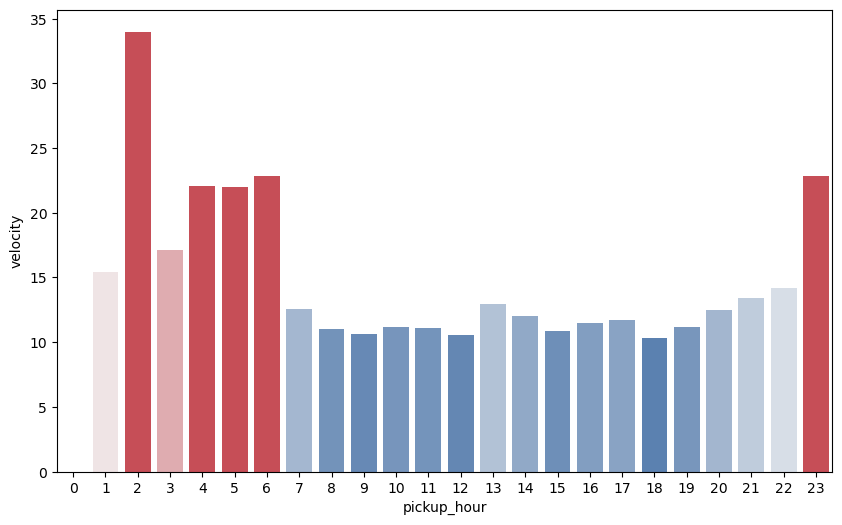

In [24]:
# You can adjust this value to control the center of the color transition
center_value = 10
intensity = (temp.velocity - center_value) / (center_value)

# Create a custom diverging color palette
custom_palette = sns.diverging_palette(250, 10, as_cmap=True)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=temp, x="pickup_hour", y="velocity", palette=custom_palette(intensity))

# Show the plot
plt.show()

As we can see, the plot shows the average velocity in each hour of the day. The higher velocities are present before and after midnight with a peak at 5am. It could be due to the low trafic and presence of pedestrians on the streets.

# Las rutas mas pagadas

In [25]:
df_filtered = df_cleaned[["PULocationID","DOLocationID","trip_distance","tolls_amount","total_amount"]]
df_filtered.head(10)

,PULocationID,DOLocationID,trip_distance,tolls_amount,total_amount
2786484,236,75,0.28,0.0,3.80
5185903,236,233,2.90,0.0,11.80
6364471,261,79,3.10,0.0,14.75
3234268,48,229,1.30,0.0,9.30
5381761,162,141,0.40,0.0,7.30
3941871,112,95,6.90,0.0,27.95
6566881,230,48,0.63,0.0,6.80
3575608,257,165,3.90,0.0,15.30
5798972,239,237,1.51,0.0,10.56
820659,41,41,0.30,0.0,4.30


Before to continue, let's add the names of the zone for a better understanding

In [45]:
df_zones = pd.read_csv("dataset/taxi_zone_lookup.csv")
df_zones.head(5)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [48]:
# Merge df_filtered with df_zones for pickup location names
merged_df = df_filtered.merge(df_zones, left_on='PULocationID', right_on='LocationID', how='left')

In [ ]:
# Rename the LocationID column to pickup_location_name
merged_df.rename(columns={'Borough': 'BoroughPickUp','ZonePickUp':}, inplace=True)

In [47]:
df_filtered["PUZone"] = df_zones[df_zones.LocationID == df_filtered.PULocationID]

ValueError: Can only compare identically-labeled Series objects

In [40]:
#Let's group the rows based on the origin and the destination of the trips
#Here, we can see the 10 of the most frequent routes 
df_filtered.groupby(["PULocationID","DOLocationID"])["total_amount"].count().sort_values(ascending=False).head(10)

PULocationID  DOLocationID
264           264             1433
237           236              606
236           236              530
              237              493
237           237              452
239           238              301
              142              294
142           239              265
79            79               252
237           162              250
Name: total_amount, dtype: int64

In [38]:
df_filtered.groupby(["PULocationID","DOLocationID"])["total_amount"].sum().sort_values(ascending=False).head(10)

PULocationID  DOLocationID
264           264             20756.51
132           230              5981.62
138           230              5490.18
237           236              5015.53
138           161              4678.01
              162              4563.90
236           237              4436.99
132           164              4110.13
              265              3873.99
230           138              3850.63
Name: total_amount, dtype: float64

# Spark operations

In [ ]:
df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("dataset/yellow_tripdata_2017-01.parquet")

In [ ]:
df.printSchema()

In [ ]:
df.count()

In [ ]:
df.describe().show()

In [ ]:
#To conver to a pandas dataframe
df = df.limit(100000).toPandas()
df.head(10)

In [ ]:
#Count null values
null_count = df.isnull().sum()
null_count

In [ ]:
df.info()

In [ ]:
#Velocidad media de los taxis en función de la hora